## 10.2 Implementing Backpropagation

In this exercise we will implement a simple multi-layer perceptron for the classic dataset of housing price prediction in Boston. We begin with loading and splitting the data, as well as normalizing the features. This is an important preprocessing step and should almost always be done!

By transforming each feature to $f' = \frac{f - \mu_f}{\sigma_f}$, where $\mu_f$ is the mean and $\sigma_f$ the standard deviation for feature $f$ in our sample set, we make sure that they are centered around zero and in comparable ranges.

**Q 10.2.1: What would a standard deviation of zero mean for a feature?**
 
**Answer:** It means that it is constant and therefore effectively contains no information, rendering it useless.

In [1]:
%matplotlib inline
import numpy as np    
import matplotlib.pyplot as plt

# Load the dataset
from sklearn.datasets import load_boston
boston = load_boston()

# Split the dataset in training and validation set
n_training_samples = 300
X_train = boston.data[:n_training_samples]
y_train = boston.target[:n_training_samples].reshape((-1, 1))
X_valid = boston.data[n_training_samples:]
y_valid = boston.target[n_training_samples:].reshape((-1, 1))

# Normalize the features by centering them around the mean 
# dividing by the standard deviation. Note that we calculate
# the statistical moments only on the training set!
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std

After loading the data, we can set up the network. We will stick to the architecture from the lecture: one hidden layer with a rectified linear activation and the output layer with linear output since this is a regression task. After setting this up, we need to be able to correctly pass data forward and backward through the network. Below the code stub here, you will find a gradient checking procedure to verify your implementation before we turn to the optimization in the next part.

**Task a) Setting up an MLP:** 
  * Implement the missing pieces of the architecture for one hidden layer with 50 units and rectified linear activation and one linear output unit
  * Implement the forward and backward pass for this architecture.
  * Verify your implementation with the gradient checking procedure.

In [2]:
# Define the network architecture
n_input_units = X_train.shape[1]
n_hidden_units = 50
n_output_units = 1

# Implement the shapes in terms of the above definitions.
# For verification and broadcasting reasons the bias 
# should have 1 row, i.e. the shape should be (1, x)
# with x determined by you.

# Every layer is a matrix multiplication plus a bias, so
# the shapes must match those operations.
hidden_weights_shape = (n_input_units, n_hidden_units)
output_weights_shape = (n_hidden_units, n_output_units)
hidden_bias_shape = (1, n_hidden_units)
output_bias_shape = (1, n_output_units)

# For the optimization with gradient descent, we have to pick an
# initial guess for the solution.
def init_weights():
    # We initialize the weights with a Gaussian distribution
    hidden_weights = np.random.standard_normal(hidden_weights_shape) * 0.1
    output_weights = np.random.standard_normal(output_weights_shape) * 0.1

    # The bias is usually initialized to zero
    hidden_bias = np.zeros(hidden_bias_shape)
    output_bias = np.zeros(output_bias_shape)

    return hidden_weights, output_weights, hidden_bias, output_bias
    
hidden_weights, output_weights, hidden_bias, output_bias = init_weights()
    
# Activation functions
def relu(x):
    # It's important to use the elementwise max function in numpy
    return np.maximum(0., x)

def linear(x):
    return x

# The forward pass for this neural network
# The output for every layer should be computed in
# two steps: before and after applying the activation
# function.
def forward_pass(X):
    hidden_linear = X.dot(hidden_weights) + hidden_bias
    hidden_act = relu(hidden_linear)
    
    output_linear = hidden_act.dot(output_weights) + output_bias
    output_act = linear(output_linear)
    
    # We collect the activations in a dictionary here,
    # because we need them for the backward pass
    activations = {
        'hidden_linear': hidden_linear,
        'hidden_act': hidden_act,
        'output_linear': output_linear,
        'output_act': output_act
    }
    
    # The prediction is in output_act
    return output_act, activations


# Loss function
# Implement the mean square error function
def squared_error(y_predicted, y):
    return np.mean(0.5 * (y_predicted - y)**2)


# This completes everything we need for the forward pass
# If you are unsure about your implementation, feel
# free to pass random values through and check the output
# shapes

# For the backward pass, we will need the
# derivatives of the activation functions and the loss function
# The gradients are defined in the slides, we just need to match
# the input shapes.
def relu_grad(x):
    dx = np.zeros_like(x)
    dx[x > 0] = 1.
    return dx

def linear_grad(x):
    return np.ones_like(x)

# The error gradient wrt the predicted y value
def squared_error_grad(y_hat, y):
    n_samples = float(y.shape[0])
    return (y_hat - y) / n_samples

# The backward pass is responsible for calculating the derivatives
# of the loss with respect to the weights and biases of each layer.
# It also helps to think about the shapes (again!)
def  backward_pass(X, y, activations):
    # For most of the gradients you already filled out helper functions. Use them!
    
    # Wherever you need the elements of the forward pass, you will find them
    # in the activations dictionary. See the forward pass for the keys or
    # print it to find out.
    
    # The first thing to calculate is the gradient of the error function wrt
    # the prediction the network made
    error_grad = squared_error_grad(activations['output_act'], y)
    
    # Now we can go backwards layer by layer
    # First derive wrt the activation function, because it is the last thing we did in
    # the forward pass
    output_act_grad = error_grad * linear_grad(activations['output_linear']) 
    
    # Two objects contributed to Xw + b: the weights and the bias
    # These are the parameters of our network and will let us update
    # the network later.
    output_weights_grad = activations['hidden_act'].T.dot(output_act_grad)
    
    # Remember that the bias was broadcasted from its shape (1, k) to 
    # (n, k) with n being the number of samples. For the correct gradient
    # you need to get back to (1, k) by summing up.
    output_bias_grad = output_act_grad.sum(axis=0, keepdims=True)
    
    # The last thing to do for the output layer is to take the derivative wrt
    # its input, so we can backpropagate the errors the previous layers need
    # to fix.
    output_inp_grad = output_act_grad.dot(output_weights.T)

    # From here on, everything is the same as for the output layer, except
    # for the changed activation function
    hidden_act_grad = output_inp_grad * relu_grad(activations['hidden_linear'])
    hidden_weights_grad = X.T.dot(hidden_act_grad)
    hidden_bias_grad = hidden_act_grad.sum(axis=0, keepdims=True)
    
    # These are the gradients we care about in the end, because
    # we need them to update our network
    gradients = (
        output_weights_grad,
        output_bias_grad,
        hidden_weights_grad,
        hidden_bias_grad
    )
    
    return gradients

** Q 10.2.2: Remember how the regularization for polynomial models worked. How could you apply it here?**

**Answer:** We can punish large activations by adding an additional squared loss term on the weights of the hidden and output layer to the final error function. During the backward pass the weights will then have an additional gradient describing their contribution to this so called L2 norm.

#### Gradient Checking

Although everything is in place to turn our attention to training networks, it is always a good idea to verify the gradients of your network. Although there are nowadays lots of frameworks to compute the gradients for you, we use a (central) finite difference approximation to make sure the implementation is correct:

\begin{equation}
\frac{ \mathcal{L}(\theta + \epsilon, X) - \mathcal{L}(\theta - \epsilon, X)}{2 \epsilon} \approx \frac{\partial \mathcal{L}(\theta, X)}{\partial \theta}
\end{equation}

Looks familiar? For vanishing $\epsilon$ the left term is the definition of the derivative of the loss function $\mathcal{L}$ with respect to $\theta$. With a small enough $\epsilon$, we can validate the backward pass. If the code below does not print anything, you're golden!

Note though, that this method isn't perfect and the finite precision of floating point numbers sometimes interferes even with correct code. If you think this happens in your case, try changing the threshold and the epsilon, but in almost every case the current settings should work fine.

In [3]:
def check_gradients():
        X_test = np.random.standard_normal((30, n_input_units))
        y_test = np.random.standard_normal((30, n_output_units))
    
        y_pred, act = forward_pass(X_test)
        owg, obg, hwg, hbg = backward_pass(X_test, y_test, act)
        
        def check_param(param, grad_est, epsilon=1e-7, error_threshold=1e-3):
            if np.any(np.isnan(param)):
                print('Parameters not implemented (NaN).')
                return False
            
            orig = param.copy()
            for i in range(param.shape[0]):
                for j in range(param.shape[1]):
                    if np.any(np.isnan(grad_est)):
                        print('NaNs detected')
                        return False
                    
                    param[:] = orig.copy()
                    param[i, j] = orig[i, j] + epsilon
                    loss_plus = squared_error(forward_pass(X_test)[0], y_test)
                    param[i, j] = orig[i, j] - epsilon
                    loss_minus = squared_error(forward_pass(X_test)[0], y_test)
                    g = (loss_plus - loss_minus) / (2 * epsilon)
                    
                    if np.abs(g - grad_est[i, j]) > error_threshold:
                        print('Finite difference:', g)
                        print('Yours: ', grad_est[i, j])
                        return False
                    
            return True
        
        if not check_param(output_weights, owg):
            print('Output weight gradient incorrect!')
        if not check_param(output_bias, obg):
            print('Output bias gradient incorrect!')
        if not check_param(hidden_weights, hwg):
            print('Hidden weight gradient incorrect!')
        if not check_param(hidden_bias, hbg):
            print('Hidden bias gradient incorrect!')            

check_gradients()

We are almost able to actually train our network. There is just one last thing missing:

**Task b) Updating the weights: ** Complete the training loop and implement the Gradient Descent updates using the gradients from the previous task.

It is also highly encouraged that you play around with the number of hidden units, weight initialization, epochs and learning rate.

Epoch 0
	Training loss: 357.7
	Validation loss: 191.1
Epoch 50
	Training loss: 211.6
	Validation loss: 100.0
Epoch 100
	Training loss: 41.4
	Validation loss: 121.4
Epoch 150
	Training loss: 14.0
	Validation loss: 368.2
Epoch 200
	Training loss: 9.3
	Validation loss: 384.9
Epoch 250
	Training loss: 7.6
	Validation loss: 349.1


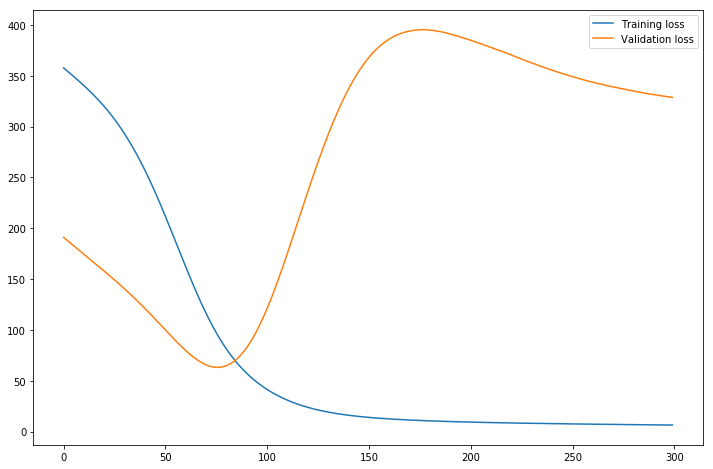

In [4]:
# Hyperparameters
n_epochs = 300
learning_rate = 1e-3

# We keep track of training and validation error
# for every episode.
training_loss = np.ones(n_epochs) * np.nan
valid_loss = np.ones(n_epochs) * np.nan

hidden_weights, output_weights, hidden_bias, output_bias = init_weights()

# The training loop
for i in range(n_epochs):
    # Use your previously implemented methods to
    # Calculate the gradient for X_train
    y_hat, activations = forward_pass(X_train)
    
    # Get the gradients for the weights and biases
    # from our backward pass function
    gradients = backward_pass(X_train, y_train, activations)
    output_weight_grad = gradients[0]
    output_bias_grad = gradients[1]
    hidden_weight_grad = gradients[2]
    hidden_bias_grad = gradients[3]

    # Do a forward pass to evaluate the validation data
    y_hat_valid, _ = forward_pass(X_valid)
    
    # We need to know how the network performs,
    # so we should evaluate the loss on training and validation set
    training_loss[i] = squared_error(y_hat, y_train)
    valid_loss[i] = squared_error(y_hat_valid, y_valid)
    
    output_weights = output_weights - learning_rate * output_weight_grad
    output_bias = output_bias - learning_rate * output_bias_grad
    hidden_weights = hidden_weights - learning_rate * hidden_weight_grad
    hidden_bias = hidden_bias - learning_rate * hidden_bias_grad
    
    if i % 50 == 0:
        print('Epoch {:d}'.format(i))
        print('\tTraining loss: {:.1f}'.format(training_loss[i]))
        print('\tValidation loss: {:.1f}'.format(valid_loss[i]))

plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(loc='best')

** Q 10.2.3: What is the effect of rather small or large learning rates on the error?**

**Answer:** Small learning will decrease the error slowly or not at all. We simply do not adjust the weights enough to see a difference. A large learning rate on the other hand can overshoot the local minimum, i.e. adjust the weights too much. 

Estimating the gradient only determines the direction we need to follow, but does not tell us how large a step we should take. The learning rate is a hyperparameter to control this step size and strongly influences the speed of convergence to a local minimum.

** Q 10.2.4: Do you see a problem with using the same learning rate for all weights in the MLP?**

**Answer:** Different weights might require different adjustments, especially for different layers or for different numbers of incoming units. Weight initialisation also plays a big role in this and many variants of gradient descent keep a separate learning rate for each weight, that is adjusted heuristically.